In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# create Python 3.11 env and register as a Jupyter kernel
# !conda create -y -n logit_graph_py311 python=3.11
# !conda run -n logit_graph_py311 python -m pip install -U pip setuptools wheel
# !conda run -n logit_graph_py311 python -m pip install -e "/Users/maruanottoni/home/master/research/logit-graph"
# !conda run -n logit_graph_py311 python -m ipykernel install --user --name logit_graph_py311 --display-name "Python (logit_graph_py311)"
#from logit_graph import LogitGraphFitter

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [3]:
import sys
import os
sys.path.append('../..')

#Graph imports
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
FOLDER_OUTPUT = f'runs/fitted_graphs_comparison_twitch'
out_files = os.listdir(FOLDER_OUTPUT)
out_files = sorted(out_files, key=lambda x: os.path.getctime(os.path.join(FOLDER_OUTPUT, x)), reverse=True)

out_files

['comparators_DE_graph_sample.pkl',
 'comparators_ENGB_graph.pkl',
 'comparators_FR_graph.pkl',
 'comparators_ENGB_graph_sample.pkl',
 'comparators_FR_graph_sample.pkl',
 'comparators_ES_graph_sample.pkl',
 'comparators_ES_graph.pkl',
 'comparators_RU_graph.pkl',
 'comparators_PTBR_graph.pkl']

In [ ]:
import sys, importlib, pickle
sys.modules['src.simulation'] = importlib.import_module('src.logit_graph.simulation')  # or 'logit_graph.simulation'

comparators_all = []

for file in out_files:
    print(file)
    with open(f'{FOLDER_OUTPUT}/{file}', 'rb') as f:
        comparators = pickle.load(f)
        comparators_all.extend(comparators)

comparators_DE_graph_sample.pkl


In [93]:
dfs = []
for i in range(len(comparators_all)):
    df = comparators_all[i].summary_df
    # Check if graph_filename already exists in dfs
    if not any(df['graph_filename'].iloc[0] in existing_df['graph_filename'].values for existing_df in dfs):
        dfs.append(df)

In [94]:
# Remove dupplicate rows
pd.concat(dfs)

,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,RU_graph.edges,Original,NaN,N/A,True,4385,37304,0.003881,0.165797,3.021095,9,-0.182289,1,4385
1,RU_graph.edges,LG,0.189576,"d=0, sigma=-6.1578",True,4385,18807,0.001957,0.001833,4.141792,7,-0.007134,3,4383
2,RU_graph.edges,BA,0.410948,5.0,True,4385,21900,0.002278,0.013018,3.438293,5,-0.035730,1,4385
3,RU_graph.edges,WS,1.058631,20.2,True,4385,39465,0.004106,0.003678,3.196503,5,-0.032727,1,4385
4,RU_graph.edges,ER,2.172463,0.01,True,4385,96117,0.010000,0.009979,2.628596,4,0.002416,1,4385
5,RU_graph.edges,GRG,8.557508,1.0,True,4385,9380390,0.975912,0.978840,1.024088,2,-0.033350,1,4385
0,ES_graph.edges,Original,NaN,N/A,True,4648,59382,0.005499,0.222496,2.883191,9,-0.189051,1,4648
1,ES_graph.edges,LG,0.246086,"d=1, sigma=-6.9104",True,4648,29905,0.002769,0.002571,3.592971,6,-0.002843,1,4648
2,ES_graph.edges,BA,0.306256,5.0,True,4648,23215,0.002150,0.013228,3.442635,5,-0.041685,1,4648
3,ES_graph.edges,ER,1.075509,0.01,True,4648,108346,0.010032,0.009995,2.610147,3,0.001618,1,4648


In [95]:
# remove dupplicate rows across df and dfs
#dfs = [df.drop_duplicates() for df in dfs]

len(dfs)
dfs[0]


,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,RU_graph.edges,Original,NaN,N/A,True,4385,37304,0.003881,0.165797,3.021095,9,-0.182289,1,4385
1,RU_graph.edges,LG,0.189576,"d=0, sigma=-6.1578",True,4385,18807,0.001957,0.001833,4.141792,7,-0.007134,3,4383
2,RU_graph.edges,BA,0.410948,5.0,True,4385,21900,0.002278,0.013018,3.438293,5,-0.035730,1,4385
3,RU_graph.edges,WS,1.058631,20.2,True,4385,39465,0.004106,0.003678,3.196503,5,-0.032727,1,4385
4,RU_graph.edges,ER,2.172463,0.01,True,4385,96117,0.010000,0.009979,2.628596,4,0.002416,1,4385
5,RU_graph.edges,GRG,8.557508,1.0,True,4385,9380390,0.975912,0.978840,1.024088,2,-0.033350,1,4385


In [96]:
# Create a DataFrame with GIC values for each model and graph, including node and edge count
gic_df = pd.DataFrame()

for df in dfs:
    graph_name = df['graph_filename'].iloc[0]
    # Get GIC values for each model (excluding Original which has NaN)
    model_gics = df[df['model'] != 'Original'].set_index('model')['gic_value']
    # Add node and edge count from the Original model
    original_row = df[df['model'] == 'Original'].iloc[0]
    model_gics['nodes'] = original_row['nodes']
    model_gics['edges'] = original_row['edges']
    gic_df[graph_name] = model_gics

# Transpose so graphs are rows and models are columns
gic_df = gic_df.T
gic_df

model,LG,BA,WS,ER,GRG,nodes,edges
RU_graph.edges,0.189576,0.410948,1.058631,2.172463,8.557508,4385.0,37304.0
ES_graph.edges,0.246086,0.306256,1.226700,1.075509,6.910762,4648.0,59382.0
PTBR_graph.edges,0.328175,0.495998,1.385952,0.629600,4.865420,1912.0,31299.0


In [97]:
# Create a dictionary to store rankings for each graph
rankings = {}

# Go through each df in dfs
for df in dfs:
    graph_name = df['graph_filename'].iloc[0]  # Get graph filename
    
    # Sort models by GIC value (excluding 'Original' which has NaN GIC)
    model_ranks = df[df['model'] != 'Original'].sort_values('gic_value')['model'].tolist()
    
    # Create rankings dictionary for this graph (1 is best since lowest GIC is best)
    rankings[graph_name] = {
        model: rank+1 for rank, model in enumerate(model_ranks)
    }
    
    # Add nodes and edges from Original model
    original_row = df[df['model'] == 'Original'].iloc[0]
    rankings[graph_name]['nodes'] = original_row['nodes']
    rankings[graph_name]['edges'] = original_row['edges']

# Get unique models (excluding 'Original')
models = sorted(list(set([model for df in dfs for model in df['model'].unique() if model != 'Original'])))

# Create DataFrame with rankings
ranking_df = pd.DataFrame(rankings).T

# Ensure all models are present as columns
for model in models:
    if model not in ranking_df.columns:
        ranking_df[model] = np.nan

# Keep only the model columns in a consistent order, plus nodes and edges
ranking_df = ranking_df[models + ['nodes', 'edges']]

print("Rankings by GIC value (lower is better):")
display(ranking_df)


Rankings by GIC value (lower is better):


,BA,ER,GRG,LG,WS,nodes,edges
RU_graph.edges,2,4,5,1,3,4385,37304
ES_graph.edges,2,3,5,1,4,4648,59382
PTBR_graph.edges,2,3,5,1,4,1912,31299


In [98]:
ranking_df.mean(axis=0)

BA           2.000000
ER           3.333333
GRG          5.000000
LG           1.000000
WS           3.666667
nodes     3648.333333
edges    42661.666667
dtype: float64

In [99]:
ranking_df['nodes'].describe()

count       3.000000
mean     3648.333333
std      1509.447691
min      1912.000000
25%      3148.500000
50%      4385.000000
75%      4516.500000
max      4648.000000
Name: nodes, dtype: float64

In [100]:
len(ranking_df)

3

# Gen all Plots

In [112]:
# Sort comparators_all by number of nodes in real graph
comparators_all = sorted(comparators_all, 
                        key=lambda x: x.fitted_graphs_data['Original']['graph'].number_of_nodes())


twitch_0_PTBR_graph.edges


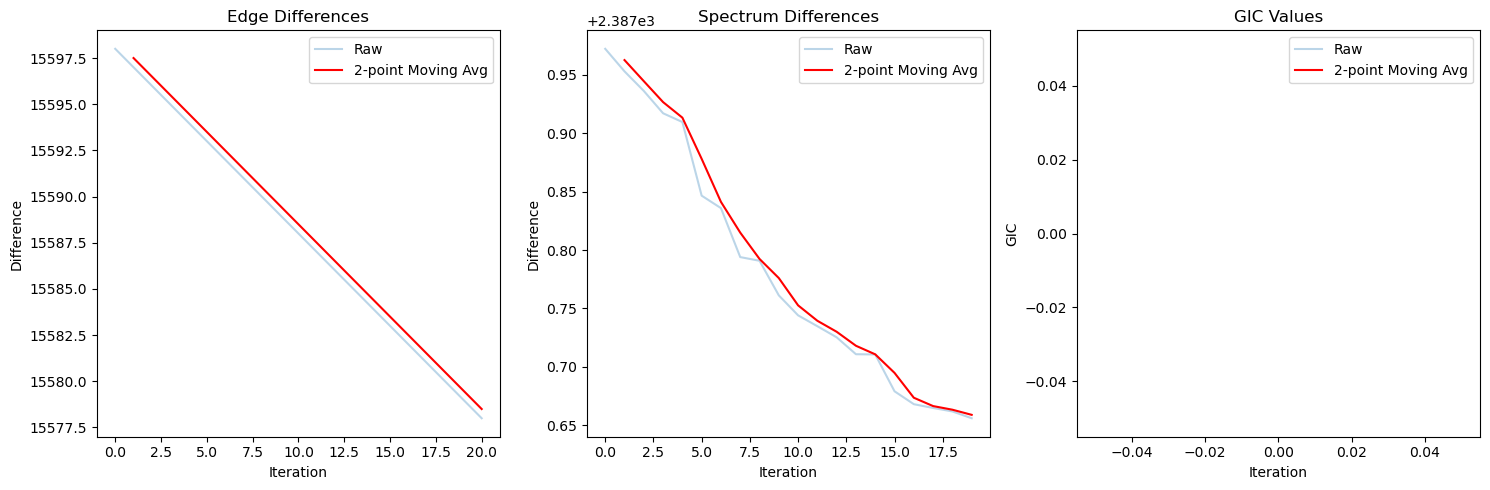

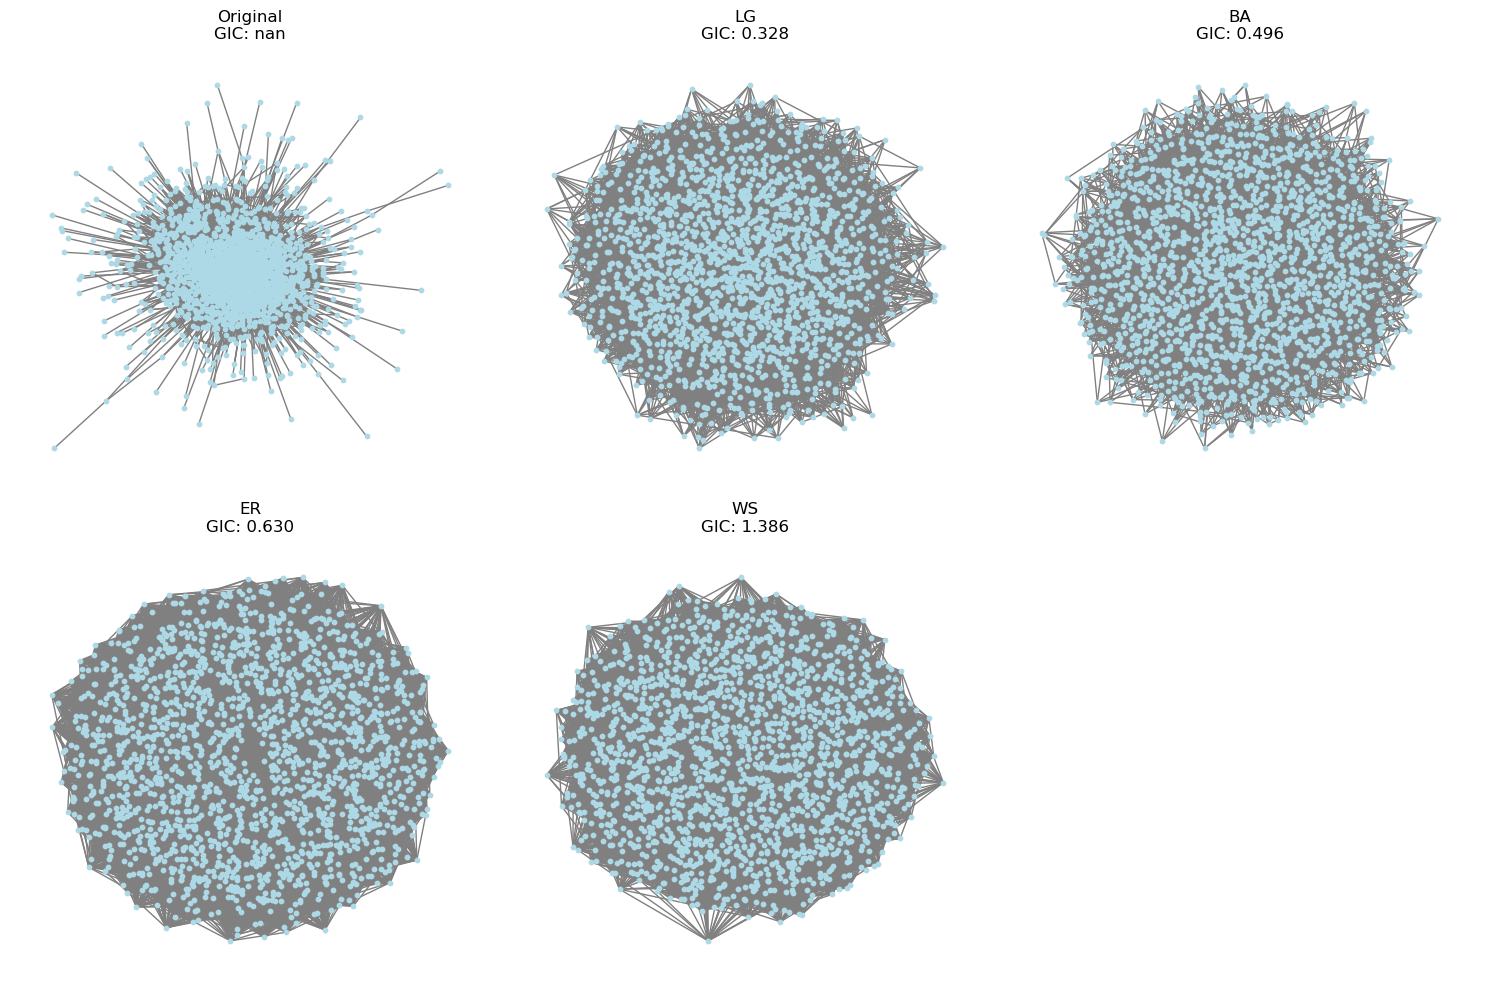

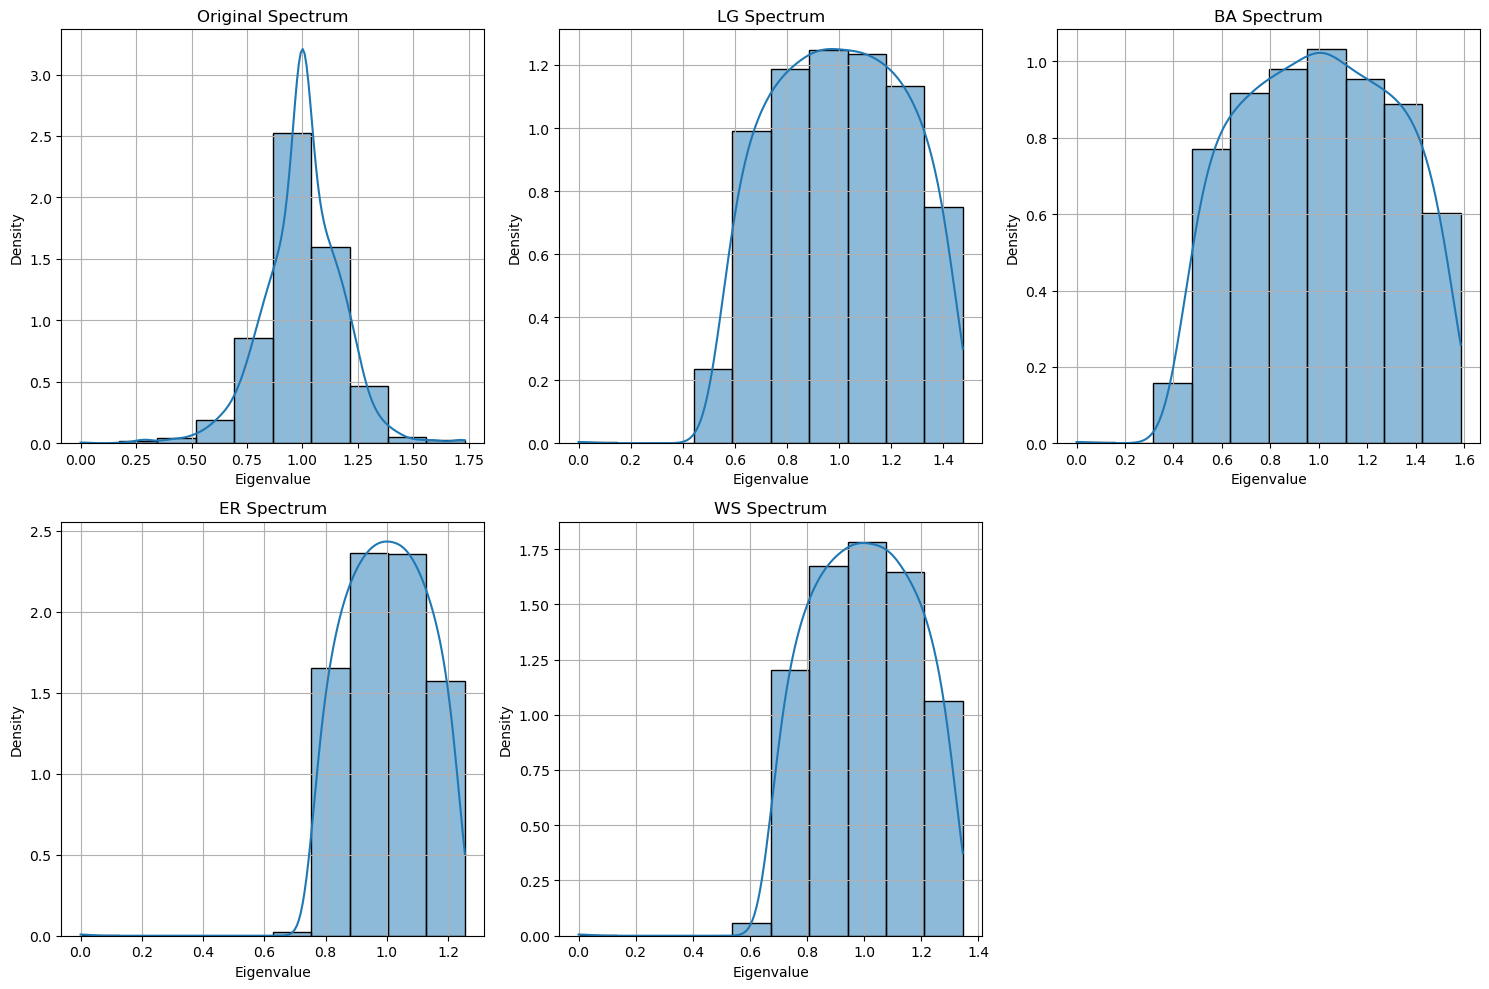

twitch_1_RU_graph.edges


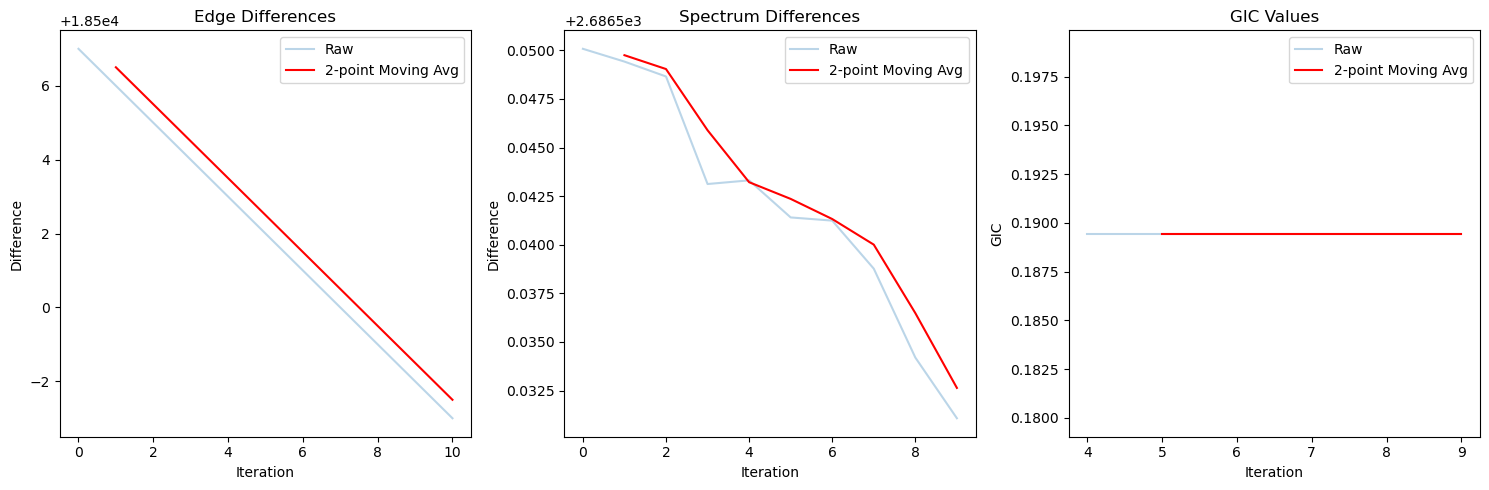

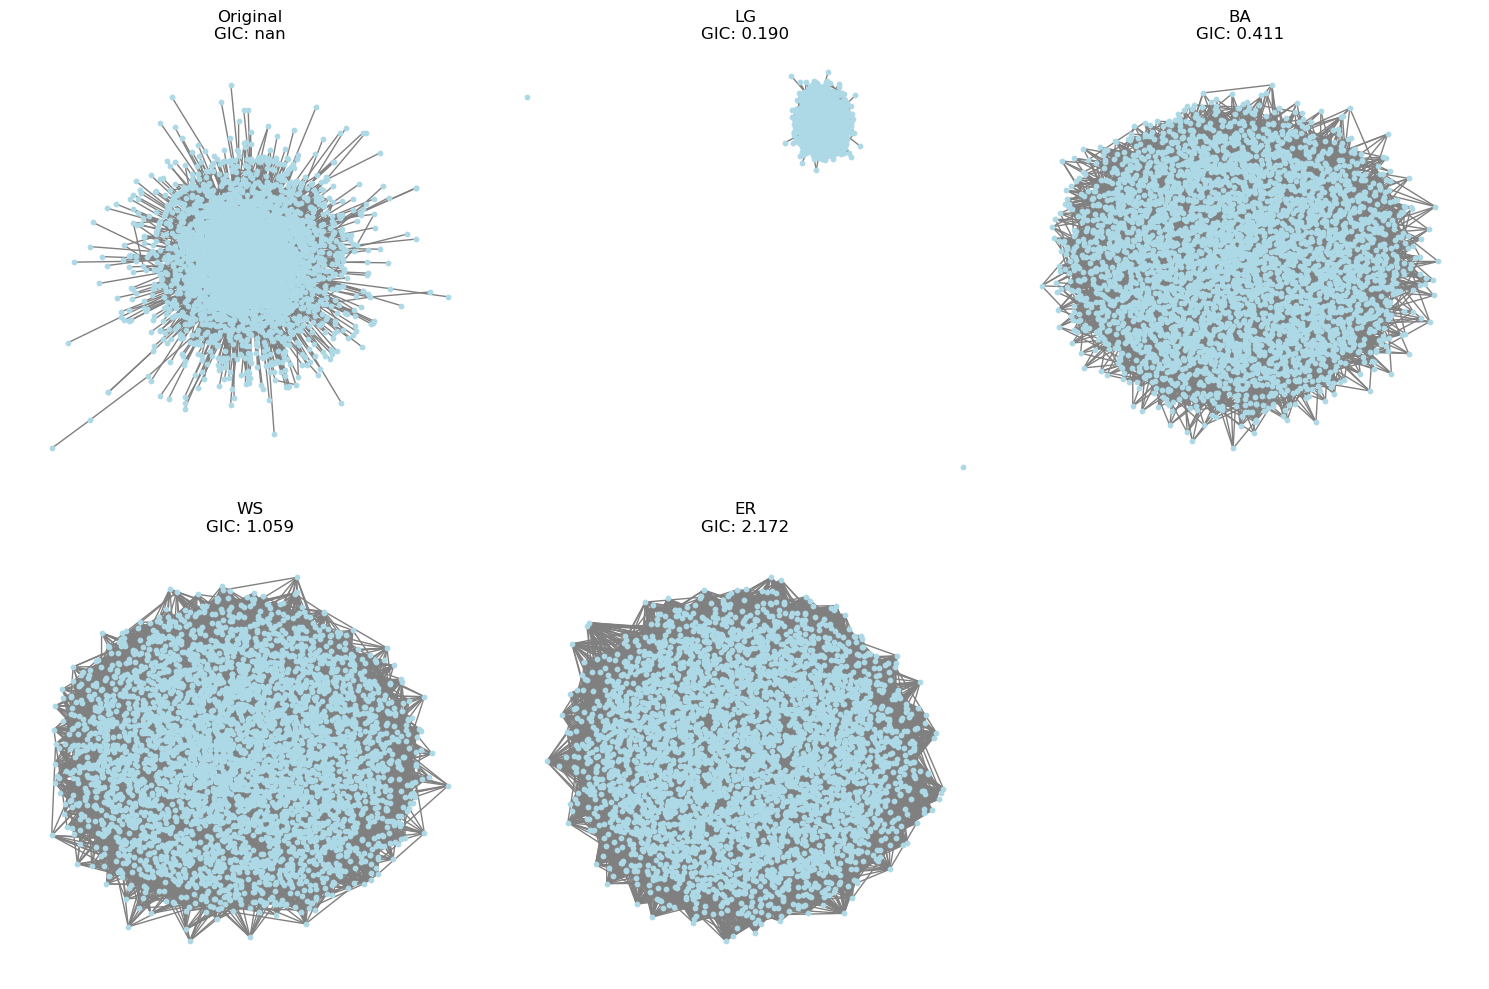

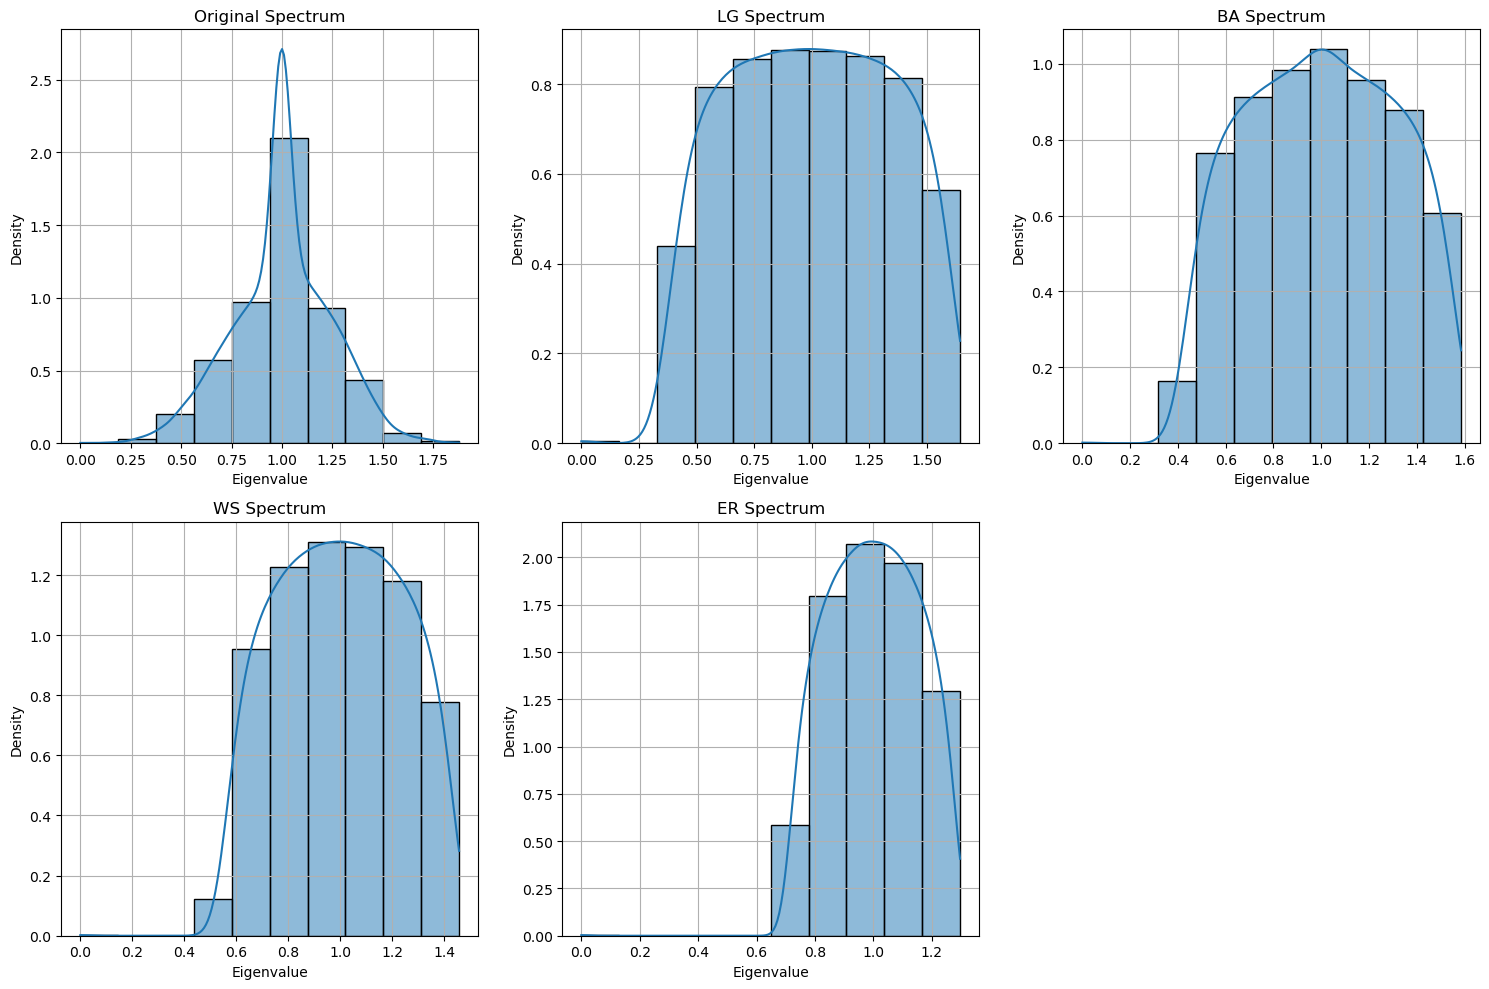

twitch_2_RU_graph.edges


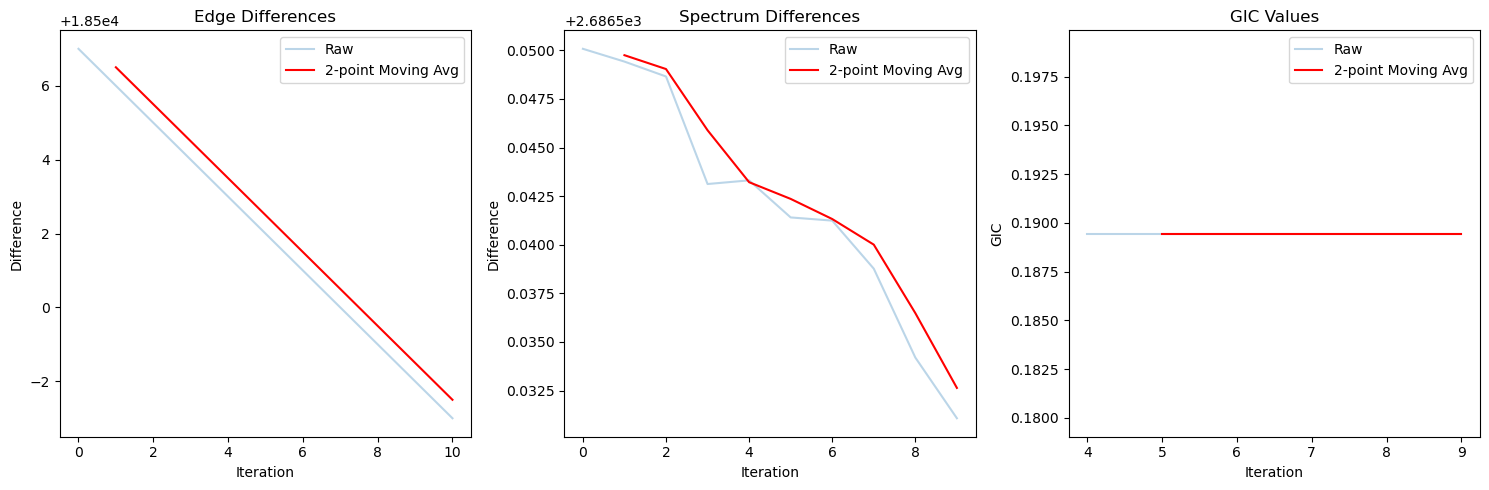

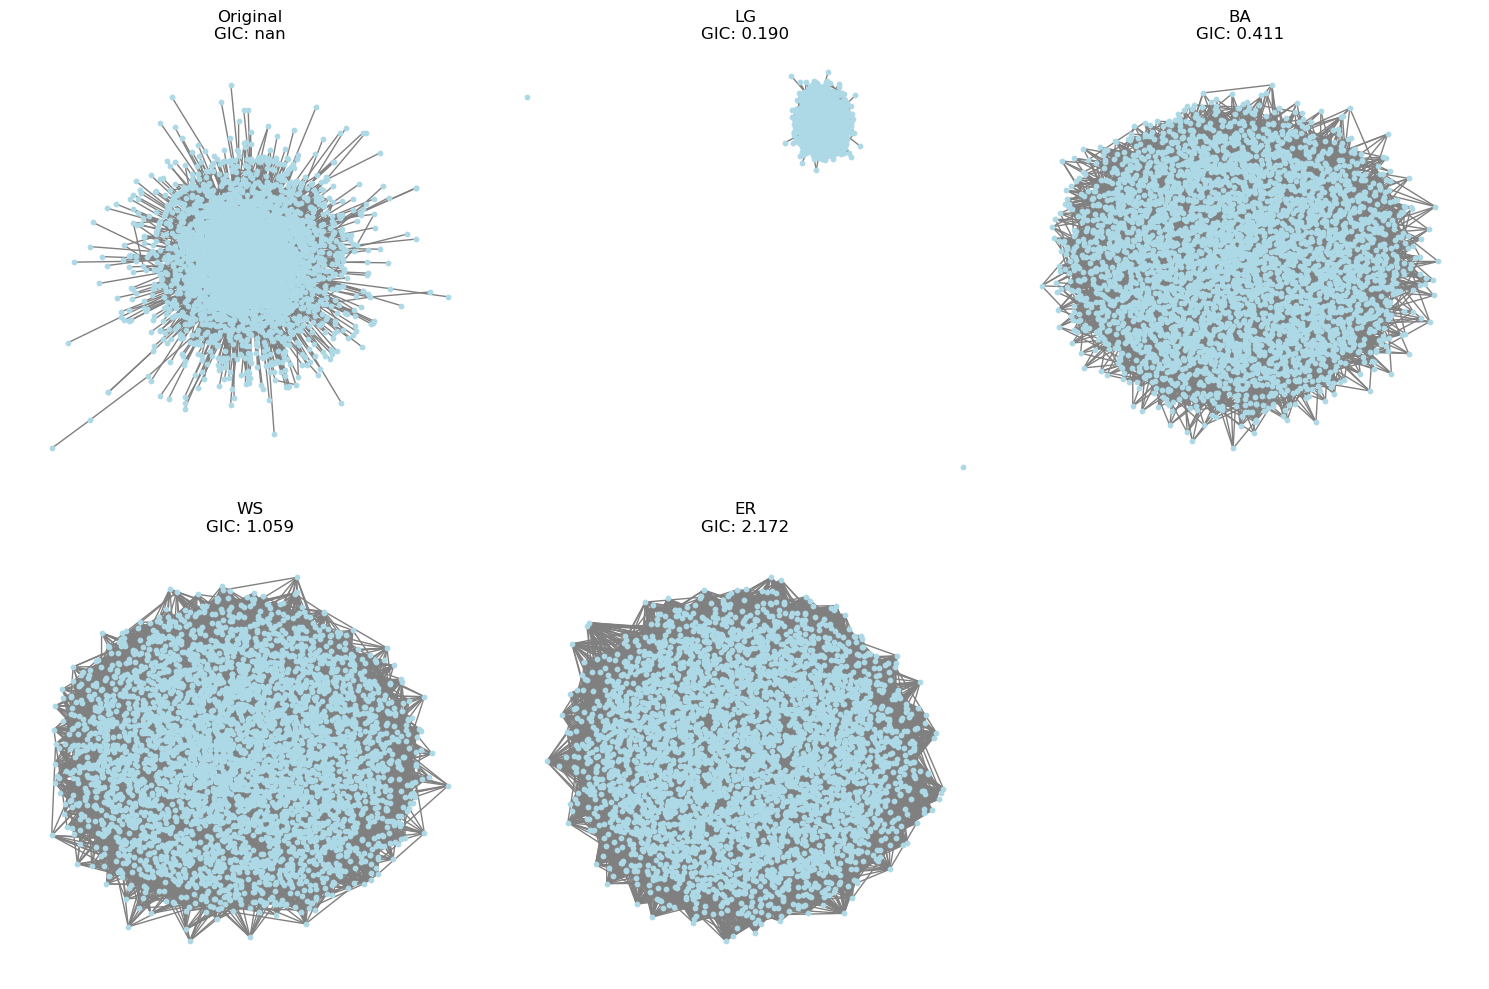

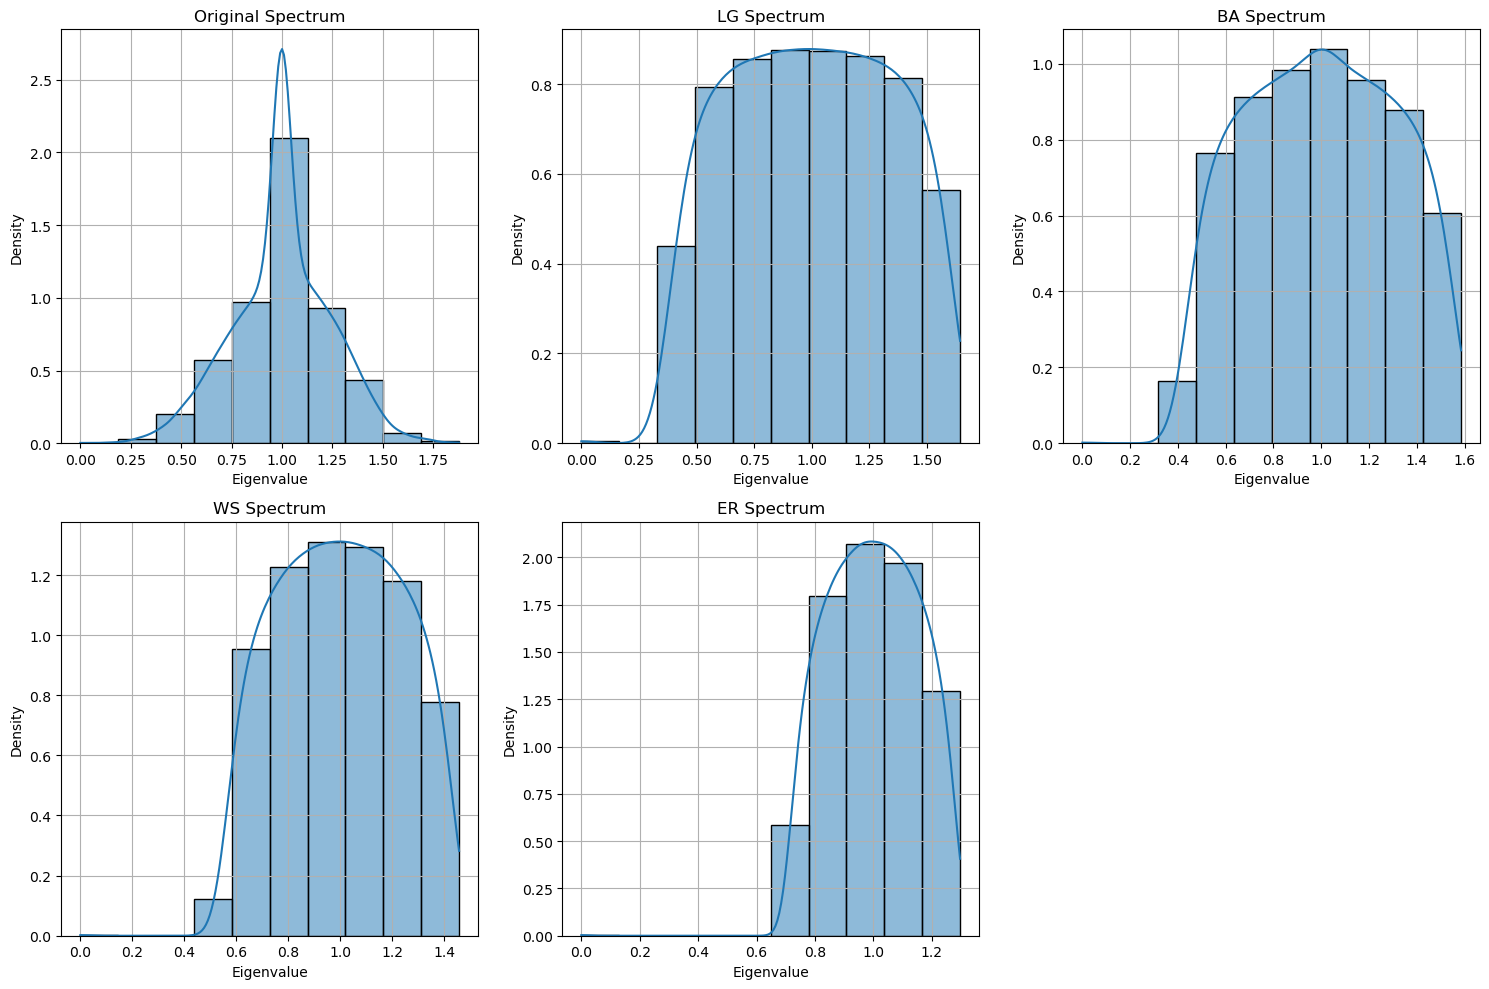

twitch_3_ES_graph.edges


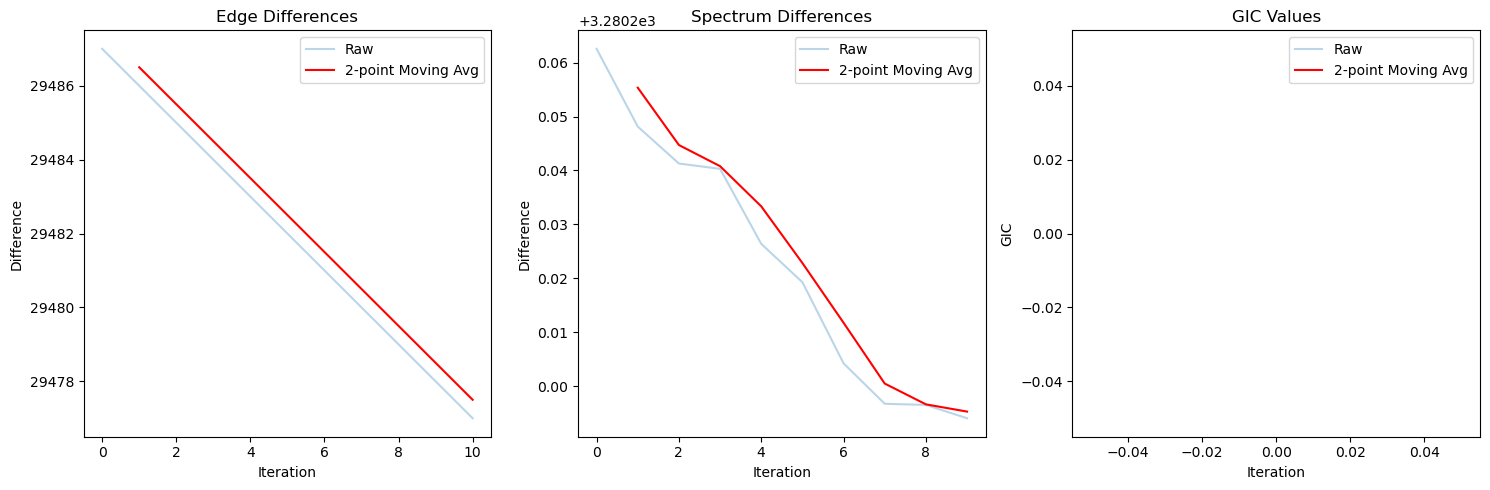

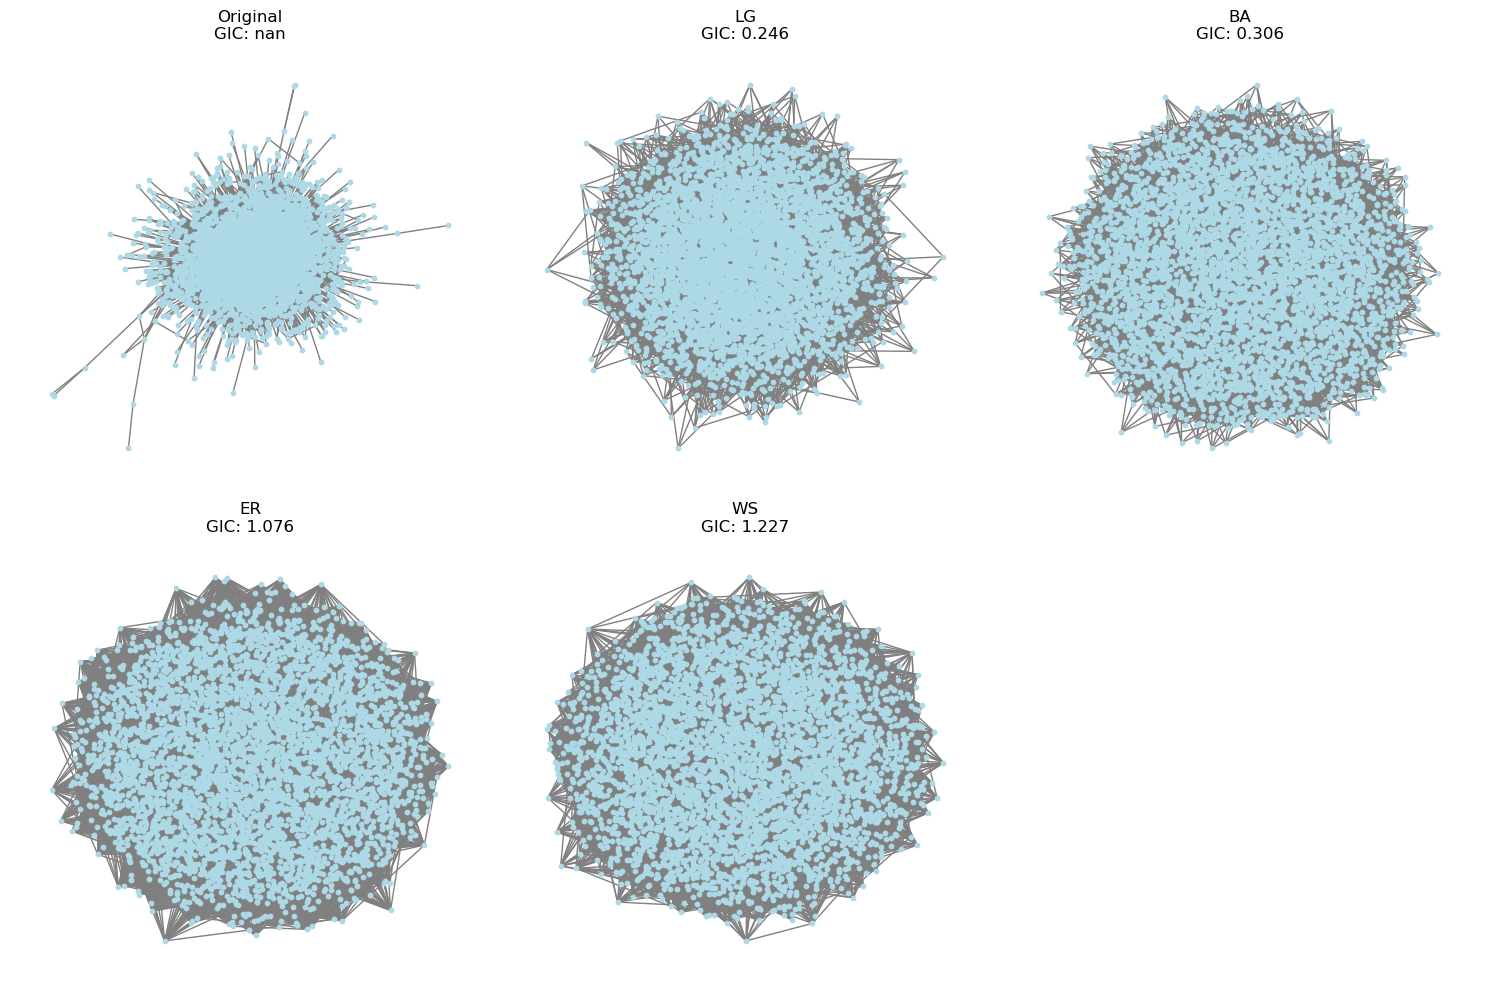

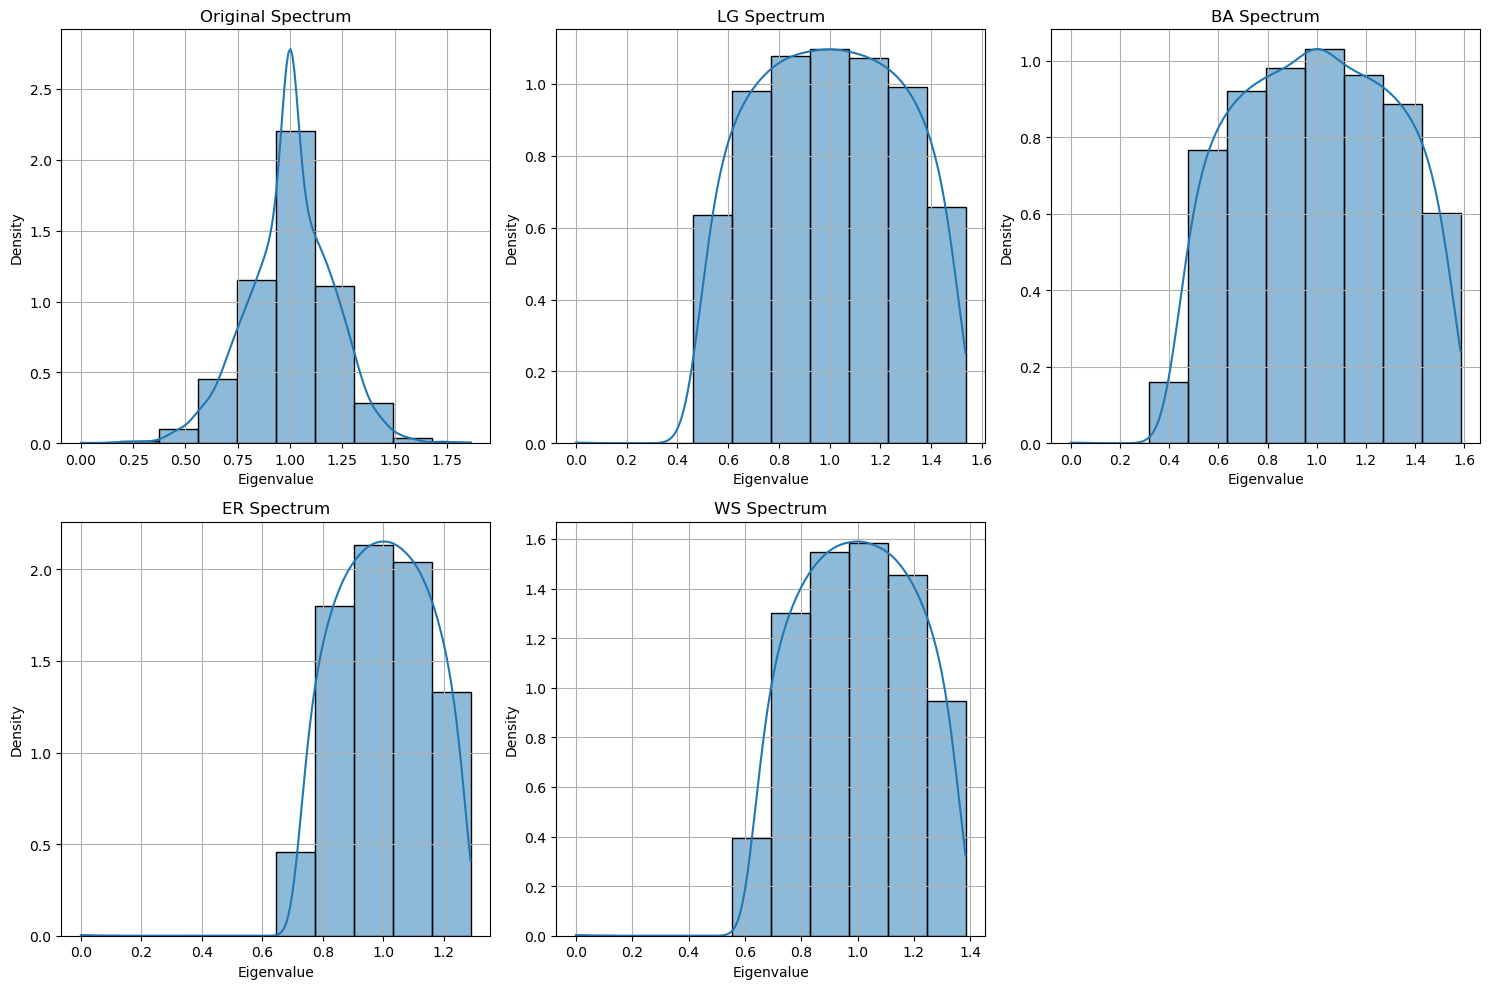

In [113]:

folder = 'imgs_twitch'
os.makedirs(f'{folder}', exist_ok=True)

# Gen all plots
for i in range(len(comparators_all)):
    graph = comparators_all[i]
    graph_name = f'twitch_{i}_{graph.summary_df.graph_filename.iloc[0]}'
    print(graph_name)

    spec_diff = graph.fitted_graphs_data['LG']['metadata']['spectrum_diffs']
    edge_diff = graph.fitted_graphs_data['LG']['metadata']['edge_diffs']
    gic_values = graph.fitted_graphs_data['LG']['metadata']['gic_values']

    # Calculate moving averages with window size of 10
    window = 2
    edge_diff_ma = pd.Series(edge_diff).rolling(window=window).mean()
    spec_diff_ma = pd.Series(spec_diff).rolling(window=window).mean()
    gic_values_ma = pd.Series(gic_values).rolling(window=window).mean()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.plot(edge_diff, alpha=0.3, label='Raw')
    plt.plot(edge_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Edge Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(spec_diff, alpha=0.3, label='Raw')
    plt.plot(spec_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Spectrum Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(gic_values, alpha=0.3, label='Raw')
    plt.plot(gic_values_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('GIC Values')
    plt.xlabel('Iteration')
    plt.ylabel('GIC')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_iteration.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph2 = data['graph']
        pos = nx.spring_layout(graph2, seed=42)
        
        nx.draw(graph2, pos, ax=axes[i], 
                node_size=10,
                node_color='lightblue',
                edge_color='gray',
                with_labels=False)
        
        # Add title with model name and key metrics
        attrs = data['attributes']
        gic = data['metadata'].get('gic_value', 'N/A')
        title = f"{model}\n"
        # title += f"Nodes: {attrs['nodes']}, Edges: {attrs['edges']}\n"
        # title += f"Density: {attrs['density']:.2f}\n"
        # title += f"Avg Clustering: {attrs['avg_clustering']:.2f}\n"
        title += f"GIC: {gic:.3f}" if isinstance(gic, float) else f"GIC: {gic}"
        axes[i].set_title(title)

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_graph.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot spectrum for each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph = data['graph']
        
        try:
            # Calculate eigenvalues
            L = nx.normalized_laplacian_matrix(graph)
            eigenvalues = np.linalg.eigvals(L.toarray())
            eigenvalues = np.real(eigenvalues)  # Get real parts
            
            # Plot histogram and KDE with reduced number of bins
            sns.histplot(data=eigenvalues, kde=True, ax=axes[i], stat='density', bins=10)
            axes[i].set_title(f"{model} Spectrum")
            axes[i].set_xlabel("Eigenvalue")
            axes[i].set_ylabel("Density")
            axes[i].grid(True)
        except MemoryError:
            axes[i].text(0.5, 0.5, "Memory Error", ha='center', va='center')
            axes[i].set_title(f"{model} Spectrum (Failed)")

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_spectrum.png', bbox_inches='tight', dpi=300)

    plt.show()



In [ ]:
123

123